<a href="https://colab.research.google.com/github/miguel-rg/fluidic_memristor/blob/main/fluidic_memristor_phenomenological_mnodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook that reproduces the main theoretical results of the paper:

**The fluidic memristor: collective phenomena in elastohydrodynamic networks**

Alejandro Martinez-Calvo, Matthew D Biviano, Anneline Christensen, Eleni Katifori, Kaare H Jensen, Miguel Ruiz-Garcia

In [9]:
#Importing packages

import numpy as np
import scipy
from scipy.integrate import solve_ivp
import scipy.io
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import networkx as nx
import time
import sys
import os
import random
from numba import jit

In [10]:
# Some useful functions, we use Numba to speed them up

#Computing the graph Laplacian
def laplacian(E, K):
    EK = E.copy()
    EK.data *= np.repeat(K, 2)
    return EK.dot(E.transpose())


# Flow response for nonlinear valves
@jit(nopython=True)
def VV(pp,abs_press):
    ii = pp*(1+0.1*pp**4)/(1+pp**4)
    return ii

# Flow response for linear valves
@jit(nopython=True)
def VV_c(pp,slope):
    ii =  slope*pp
    return ii


# Function that controls the pressure at the "source" nodes
@jit(nopython=True)
def const_dev(t,pres_v,pres_st,pressure_rate):
    speed_protocol = pres_st/pressure_rate
    limit_change_pressure = pres_st/2
    if t <= pressure_rate:
        return -speed_protocol
    else:
        return speed_protocol

# Check that the volumes (\rho) are always positive during integration
@jit(nopython=True)
def rho_is_pos(rho):
    if rho>=0.:
        return rho
    else:
        return 0.


In [11]:
# Creating a vector with the currents and some extra components to control the boundary conditions. Applying the inverse laplacian.
# Numerical method detailed in M Ruiz-García, E Katifori, "Emergent dynamics in excitable flow systems", Physical Review E 103 (6), 062301 (2021)

@jit(nopython=True)
def fun(t,pres,Adj_dense,num_nodes,inv_m,alpha,lap,pres_st,num_sources_1,num_sources_2,num_sources,pressure_rate,node_list_1,node_list_2,slope,vervalize=False):

    rho = (1-alpha*lap.dot(pres[0:-num_sources]))

    ff = np.zeros(num_nodes+num_sources)

    for jj2 in range(num_nodes):
        if jj2 not in node_list_1 and jj2 not in node_list_2:
            for jj1 in np.where(Adj_dense[jj2] == 1)[0]:

                if jj1 not in node_list_1 and jj1 not in  node_list_2:
                    if pres[jj1]-pres[jj2]>=0:
                        ff[jj2] = ff[jj2] + rho_is_pos(rho[jj1])**2*VV(pres[jj1]-pres[jj2],pres[jj1])
                    else:
                        ff[jj2] = ff[jj2] + rho_is_pos(rho[jj2])**2*VV(pres[jj1]-pres[jj2],pres[jj2])
                else:
                    if pres[jj1]-pres[jj2]>=0:
                        ff[jj2] = ff[jj2] + VV_c(pres[jj1]-pres[jj2],slope)
                    else:
                        ff[jj2] = ff[jj2] + rho_is_pos(rho[jj2])**2*VV_c(pres[jj1]-pres[jj2],slope)

        else:
            for jj1 in np.where(Adj_dense[jj2] == 1)[0]:
                if jj1 not in node_list_1 and jj1 not in node_list_2:
                    if pres[jj1]-pres[jj2]>=0:
                        ff[jj2] = ff[jj2] + rho_is_pos(rho[jj1])**2*VV_c(pres[jj1]-pres[jj2],slope)
                    else:
                        ff[jj2] = ff[jj2] + VV_c(pres[jj1]-pres[jj2],slope)

    for h22 in range(1,num_sources_1+1):
        ff[-num_sources_2-h22] = const_dev(t,pres[node_list_1[num_sources_1-h22]],pres_st,pressure_rate)

    for h23 in range(1,num_sources_2+1):
        ff[-h23] = 0

    ff = inv_m.dot(ff)

    return ff



In [12]:

# Some functions that we use during the time integration
def event_min_rho(t,pres,alpha,lap,num_sources,no_sour_nodes):
    rho = (1-alpha*lap.dot(pres[0:-num_sources]))[no_sour_nodes]
    return rho.min() - 1e-10

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


#TIME INTEGRATION
def Nonlinear_network_oscilations(time_f,alpha,source,G,pos,max_step_int,pressure_rate,time_eval,slope):

    max_step_int_real = max_step_int

    pres_st = source['strength']

    times =(0,time_f)

    K = np.ones(G.number_of_edges())
    E = nx.incidence_matrix(G, oriented=True,
                                edgelist=G.graph['edgelist'],
                                nodelist=G.graph['nodelist'])

    lap = -laplacian(E, K)

    MM=np.zeros(G.number_of_nodes())
    MM[source['node1'][0]] = 1.

    for nnn in source['node1'][1:]:
        new_col = np.zeros(G.number_of_nodes())
        new_col[nnn]=1
        MM = np.c_[ MM, new_col ]

    for nnn in source['node2']:
        new_col = np.zeros(G.number_of_nodes())
        new_col[nnn]=1
        MM = np.c_[ MM, new_col ]

    MM = scipy.sparse.bmat(MM)

    # Laplacian with extra columns and rows for the boundary conditions
    L = scipy.sparse.bmat([
    [lap, MM],
    [MM.transpose(),None]
    ])

    lap_red = L.tocsc()

    inv_m =  -1/alpha* scipy.sparse.linalg.inv(lap_red)

    num_sources = len(source['node1']) + len(source['node2'])

    pres_0 = np.zeros(G.number_of_nodes()+num_sources)

    Adj = nx.adjacency_matrix(G,nodelist=G.graph['nodelist'])

    num_sources_1 = len(source['node1'])
    num_sources_2 = len(source['node2'])
    num_sources = num_sources_1 +  num_sources_2

    nn = [[mm for mm in scipy.sparse.find(Adj[[n2],:])[1] ] for n2 in range(G.number_of_nodes())]

    inv_m_dense = inv_m.todense()
    lap_dense = lap.todense()
    Adj_dense = Adj.toarray()

    fun_wr=lambda t, y: fun(t,y,Adj_dense,G.number_of_nodes(),inv_m_dense,alpha,lap_dense,pres_st,num_sources_1,num_sources_2,num_sources,pressure_rate,source['node1'],source['node2'],slope,vervalize=False)

    source_indexes = source['node1'] + source['node2']
    no_sour_nodes = [nn for nn in G.nodes() if nn not in source_indexes]

    event_rho_zero = lambda t, y: event_min_rho(t,y,alpha,lap,num_sources,no_sour_nodes)
    event_rho_zero.terminal = True

    start_time_2 = time.time()

    ## TIME INTEGRATION

    stop_time = 0.
    old_t = np.array([0.])
    old_y = np.zeros([G.number_of_nodes()+num_sources,1])

    # We need to make sure that during integration the volume at every point is positive. If this
    # is not true we stop, take some steps back, and start integration again reducing the maximum step of the simulation

    steps_back = 1
    time_eval_total = time_eval

    while stop_time < time_f:

        if time_eval_total[0] != None:
            time_eval = np.array([ ttt for ttt in time_eval_total.tolist() if ttt >= old_t[-1] ])

        solution = solve_ivp(fun_wr, (old_t[-1],time_f), old_y[:,-1], events=event_rho_zero, method='LSODA', max_step = max_step_int_real, t_eval = time_eval)#rtol=10**(-10),method='LSODA', method='LSODA',

        max_step_int_real = max_step_int_real/2

        old_t = np.concatenate((old_t,solution.t[1:-1]))
        old_y = np.concatenate((old_y,solution.y[:,1:-1]),axis=1)

        stop_time = solution.t[-1]

        ind_new = find_nearest(old_t, stop_time*3/4)

        if stop_time<time_f:
            old_t = old_t[0:ind_new]
            old_y = old_y[:,:ind_new]

        print(solution.message)
        print('solution.t_events',solution.t_events)
        print("--- integration time %s seconds ---" % (time.time() - start_time_2))


    return old_t, old_y, lap

Unexpected istate in LSODA.
solution.t_events [array([], dtype=float64)]
--- integration time 0.10376572608947754 seconds ---
Unexpected istate in LSODA.
solution.t_events [array([], dtype=float64)]
--- integration time 0.13126707077026367 seconds ---
The solver successfully reached the end of the integration interval.
solution.t_events [array([], dtype=float64)]
--- integration time 3.647125482559204 seconds ---


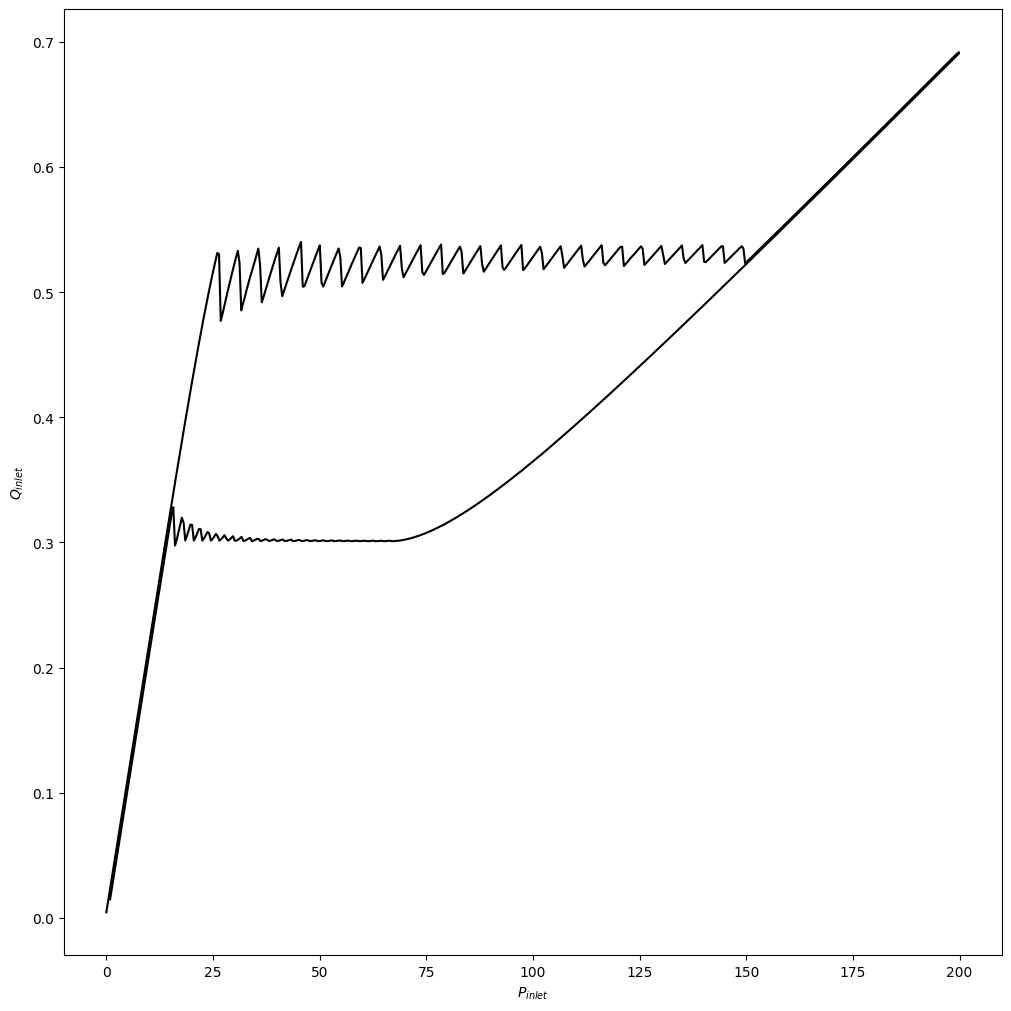

--- total time 4.373990058898926 seconds ---


In [15]:

def test():

    start_time = time.time()

    ###
    # Simulation parameters
    ###

    max_step_int = 100000 # maximum time step during integration (adaptative time steps)
    save_points_per_time = 0.00001 # if you save too often the adaptative step cannot get too large, the simulation will be slower
    alpha = 0.01 # pressure-volume coupling
    size_1d = 30 # size of graph
    time_f = 100000000 # if it is too small you get an error from the Fourier transform, also make sure you save enough steps during integration
    pres_st = 200 # maximum pressure
    slope =  0.1 # slope at the boundaries (linear valves, VV_C)
    pressure_rate = time_f/2 # rate of pressure change at the contacts
    time_eval = np.linspace(0.,time_f,num=int(save_points_per_time*time_f)) # time steps

    # Random seed
    seed_rd = 2.
    random.seed(seed_rd)
    np.random.seed(int(seed_rd))

    # Creating the graph (1D network in this case)
    G = nx.grid_graph(dim=[1, 1, size_1d], periodic= False)
    pos = dict([(i, (10*n[0] + 0.7*n[2], 10*n[1]+ 0.7*n[2])) for i, n in enumerate(G.nodes())])
    G = nx.convert_node_labels_to_integers(G)
    G.graph['pos_g'] = pos

    source = {'type': 'pressure',
                  'node1': [0],
                  'node2': [size_1d-1],
                  'strength': pres_st*alpha}

    source['node1'] = np.sort(source['node1']).tolist()
    source['node2'] = np.sort(source['node2']).tolist()

    G.graph['edgelist'] = sorted(G.edges(),  key=lambda tup: tup[0])
    G.graph['nodelist'] = sorted(G.nodes())
    G_nn = G.number_of_nodes()
    num_sources = len(source['node1']) + len(source['node2'])

    # time integration
    ttt, yyy, lap1 = Nonlinear_network_oscilations(time_f,alpha,source,G,G.graph['pos_g'],max_step_int,pressure_rate,time_eval,slope)

    # Computing the in and out current at the contacts
    rho_t = np.zeros((len(ttt),np.shape(yyy)[0]-num_sources))
    for ii in range(len(ttt)) :
        rho_t[ii,:] = np.array((1-alpha*lap1.dot(yyy[:-num_sources,ii])))

    time_range = ttt
    time_diff = np.diff(time_range)

    ## Computing out current
    total_current_out = np.zeros(len(ttt)-1)
    for ind1 in range(len(source['node2'])):
        total_current_out += np.diff(rho_t[:,source['node2'][ind1]]-alpha*yyy[-len(source['node2'])+ind1])/time_diff

    ## Computing in current
    total_current_in = np.zeros(len(ttt)-1)
    for ind1 in range(len(source['node1'])):
        total_current_in += np.diff(rho_t[:,source['node1'][ind1]]-alpha*yyy[-len(source['node2'])-len(source['node1'])+ind1])/time_diff

    # Plotting the results

    fig = plt.figure(constrained_layout=True,figsize=(10,10))

    time_pl = len(total_current_in)

    markersize_pl = 20
    lw_pl = 5

    plt.plot(yyy[0,:int(len(ttt)/2)],-total_current_in[:int(len(ttt)/2)], 'k')
    plt.plot(yyy[0,int(len(ttt)/2):time_pl],-total_current_in[int(len(ttt)/2):time_pl], 'k')

    change_param = 350
    plt.xlabel('$P_{inlet}$')
    plt.ylabel('$Q_{inlet}$')

    plt.show()

    print("--- total time %s seconds ---" % (time.time() - start_time))


test()
